## Transaction Data Visualisation

In [1]:
# Pyspark libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit, when
from pyspark.sql.functions import *
from pyspark.sql.functions import year

# Visualisation libraries
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/30 00:11:13 WARN Utils: Your hostname, DESKTOP-1ML24G5 resolves to a loopback address: 127.0.1.1; using 172.30.135.235 instead (on interface eth0)
22/09/30 00:11:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/30 00:11:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load Dataset

In [3]:
dataset = spark.read.parquet("./../data/curated/process_data.parquet")

## Outliers

In [4]:
category = dataset.select('category').distinct()
for cat in category.collect():
    subset = dataset.filter(F.col("category") == cat[0])
    if (cat == 'retail_and_wholesale_trade'):
        subcategory = subset.select('subcategory').distinct()
        for subcat in subcategory.collect():
            sub = subset.filter(F.col("subcategory") == subcat[0])
            q3, q1 = sub.approxQuantile('dollar_value', [0.75, 0.25], 0) 
            iqr = q3 - q1
            min = q1 - 1.5*iqr
            max = q3 + 1.5*iqr

            if ('isOutlier' in dataset.columns):
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True'))
                            .otherwise(dataset.isOutlier))
            else:
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True')))
    else:
        q3, q1 = subset.approxQuantile('dollar_value', [0.75, 0.25], 0) 
        iqr = q3 - q1
        min = q1 - 1.5*iqr
        max = q3 + 1.5*iqr

        if ('isOutlier' in dataset.columns):
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True'))
                        .otherwise(dataset.isOutlier))
        else:
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True')))

DATA SET --> WITH OUTLIERS <br>

Make new column such that the "category" and the "subcategory" column are combined. We can then implement Stratified Random Sampling for plotting purposes, as the goal of SRS is to take samples from each subgroup based on the ratio of the sub-groups size to the total data-population. This insures that the presence of each sub-group is present when plotting.

In [5]:
columns_to_keep = ["dollar_value", "order_datetime", "state", "postcode", "gender", "category", "subcategory", "estimated_region_population_2021_sum", "mean_earnings_2018-19_avg"]
dataset = dataset.select(*columns_to_keep)
dataset.limit(3)

dollar_value,order_datetime,state,postcode,gender,category,subcategory,estimated_region_population_2021_sum,mean_earnings_2018-19_avg
366.23,2021-11-17,WA,6935,Female,retail_and_wholes...,others_retailing,10636,62144.0
587.4,2021-09-24,WA,6935,Female,retail_and_wholes...,department_stores,10636,62144.0
196.41,2022-05-22,WA,6935,Female,info_media_and_te...,null,10636,62144.0


In [6]:
dataset.select("subcategory").distinct().show(truncate = False)

+-----------------------------------------------+
|subcategory                                    |
+-----------------------------------------------+
|food_retailing                                 |
|null                                           |
|household_goods_retailing                      |
|clothing_footwear__personal_accessory_retailing|
|department_stores                              |
|others_retailing                               |
+-----------------------------------------------+



In [7]:
# Make new column that combines categoery and subcategory:

from pyspark.sql.functions import col, concat_ws

concat_columns = ["category", "subcategory"]
df = dataset.withColumn("category_and_subcategory", concat_ws("-", *[F.col(x) for x in concat_columns]))

In [21]:
# Inspect count of each combined category and subcategory:

no_entries = df.count()

category_distribution = df \
                        .groupBy("category_and_subcategory") \
                        .agg(
                            F.count("category_and_subcategory").alias("COUNT"),
                            F.round((((F.count("category_and_subcategory")/no_entries))*100), 4).alias("%"),
                            F.round(((F.count("category_and_subcategory")/no_entries)), 4).alias("Decimal")

                        )

category_distribution.show(truncate = False)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o238.count

In [15]:
# Total count of records for each category and subcategory: 

d = dict([(x['category_and_subcategory'], x['count']) for x in df.groupBy("category_and_subcategory").count().collect()])
print(d)

{'retail_and_wholesale_trade-department_stores': 6199881, 'rental_hiring_and_real_estate': 36695, 'retail_and_wholesale_trade-food_retailing': 347322, 'arts_and_recreation': 21218, 'others': 245753, 'retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing': 1036315, 'info_media_and_telecommunications': 1904458, 'retail_and_wholesale_trade-others_retailing': 1322275, 'retail_and_wholesale_trade-household_goods_retailing': 2500239}


In [16]:
# Proportion of each category and subcategory:

d.update((key, value/(no_entries*1.30)) for key, value in d.items())
print(d)

{'retail_and_wholesale_trade-department_stores': 0.3643196684392334, 'rental_hiring_and_real_estate': 0.002156284972788618, 'retail_and_wholesale_trade-food_retailing': 0.02040946203348926, 'arts_and_recreation': 0.0012468198542752117, 'others': 0.014441027412936945, 'retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing': 0.06089631997752927, 'info_media_and_telecommunications': 0.11191045555817047, 'retail_and_wholesale_trade-others_retailing': 0.07770000578809293, 'retail_and_wholesale_trade-household_goods_retailing': 0.1469199559634839}


In [17]:
sample_test = df.sampleBy("category_and_subcategory", fractions = d, seed = 0)
sample_test.limit(5)

dollar_value,order_datetime,state,postcode,gender,category,subcategory,estimated_region_population_2021_sum,mean_earnings_2018-19_avg,category_and_subcategory
196.41,2022-05-22,WA,6935,Female,info_media_and_te...,null,10636,62144.0,info_media_and_te...
11.16,2021-10-29,WA,6935,Female,retail_and_wholes...,clothing_footwear...,10636,62144.0,retail_and_wholes...
19.7,2021-12-24,WA,6935,Female,retail_and_wholes...,department_stores,10636,62144.0,retail_and_wholes...
53.46,2021-10-16,WA,6935,Female,retail_and_wholes...,department_stores,10636,62144.0,retail_and_wholes...
9.85,2021-04-20,WA,6935,Female,retail_and_wholes...,department_stores,10636,62144.0,retail_and_wholes...


In [18]:
no_entries = sample_test.count()

category_distribution = sample_test \
                        .groupBy("category_and_subcategory") \
                        .agg(
                            F.count("category_and_subcategory").alias("COUNT"),
                            F.round((((F.count("category_and_subcategory")/no_entries))*100), 4).alias("%"),
                            F.round(((F.count("category_and_subcategory")/no_entries)), 4).alias("Decimal")

                        )

category_distribution.show(truncate = False)

+--------------------------------------------------------------------------+-------+-------+-------+
|category_and_subcategory                                                  |COUNT  |%      |Decimal|
+--------------------------------------------------------------------------+-------+-------+-------+
|retail_and_wholesale_trade-department_stores                              |2258086|74.9123|0.7491 |
|rental_hiring_and_real_estate                                             |77     |0.0026 |0.0    |
|retail_and_wholesale_trade-food_retailing                                 |6956   |0.2308 |0.0023 |
|arts_and_recreation                                                       |23     |8.0E-4 |0.0    |
|others                                                                    |3534   |0.1172 |0.0012 |
|retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing|62749  |2.0817 |0.0208 |
|info_media_and_telecommunications                                         |213159 |7.0716 

In [19]:
print(no_entries)

3014308


In [ ]:
# Can make a function that divides the value from each value in a key-value pair to get the percentage of the likelihood of that cateogory_subcategory occurring.

In [ ]:
# https://sparkbyexamples.com/spark/spark-sampling-with-examples/

# https://towardsdatascience.com/types-of-samplings-in-pyspark-3-16afc64c95d4

# https://stackoverflow.com/questions/65615934/size-of-sample-with-sampleby-in-pyspark-2-4-0

In [20]:
sample_test = sample_test.toPandas()

22/09/30 00:25:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1053)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:238)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/abungla/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


KeyboardInterrupt: 

In [19]:
sample_test.head()

,dollar_value,order_datetime,state,postcode,gender,category,subcategory,estimated_region_population_2021_sum,mean_earnings_2018-19_avg,category_and_subcategory
0,11.16,2021-10-29,WA,6935,Female,retail_and_wholesale_trade,clothing_footwear__personal_accessory_retailing,10636.0,62144.0,retail_and_wholesale_trade-clothing_footwear__...
1,19.70,2021-12-24,WA,6935,Female,retail_and_wholesale_trade,department_stores,10636.0,62144.0,retail_and_wholesale_trade-department_stores
2,53.46,2021-10-16,WA,6935,Female,retail_and_wholesale_trade,department_stores,10636.0,62144.0,retail_and_wholesale_trade-department_stores
3,9.85,2021-04-20,WA,6935,Female,retail_and_wholesale_trade,department_stores,10636.0,62144.0,retail_and_wholesale_trade-department_stores
4,8.58,2021-08-31,WA,6935,Female,retail_and_wholesale_trade,department_stores,10636.0,62144.0,retail_and_wholesale_trade-department_stores


In [ ]:
dataset_wo_outliers = dataset.filter(F.col("isOutlier") == 'False')

In [5]:
dataset.limit(2)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,isOutlier
27093785141,1195503,1,366.23,a8514aae-18fb-454...,2021-11-17,WA,6935,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,True
28510201393,1195503,1,587.4,32fcbb45-ae51-42f...,2021-09-24,WA,6935,Female,Quam Curabitur Co...,bicycle shops - s...,c,1.86,retail_and_wholes...,department_stores,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,True


In [6]:
# Population Outlier Detection
population_q3, population_q1 = dataset_wo_outliers.approxQuantile('estimated_region_population_2021_sum', [0.75, 0.25], 0) 
population_iqr = population_q3 - population_q1
population_min = population_q1 - 1.5*population_iqr
population_max = population_q3 + 1.5*population_iqr

# Income Outlier Detection
income_q3, income_q1 = dataset_wo_outliers.approxQuantile('mean_earnings_2018-19_avg', [0.75, 0.25], 0) 
income_iqr = income_q3 - income_q1
income_min = income_q1 - 1.5*income_iqr
income_max = income_q3 + 1.5*income_iqr


final_dataset = dataset_wo_outliers.filter(((F.col("estimated_region_population_2021_sum") >= population_min) & 
                                            (F.col("estimated_region_population_2021_sum") <= population_max)) | 
                                            ((F.col("mean_earnings_2018-19_avg") >= income_min) & 
                                            (F.col("mean_earnings_2018-19_avg") <= income_max)))
final_dataset = final_dataset.withColumn('order_datetime', to_timestamp('order_datetime'))

## Distributions of Variables with and without Outliers

In [8]:
dataset.show(1, vertical = True, truncate = False)

-RECORD 0------------------------------------------------------------------------------------------
 merchant_abn                         | 27093785141                                                
 consumer_id                          | 1195503                                                    
 user_id                              | 1                                                          
 dollar_value                         | 366.23                                                     
 order_id                             | a8514aae-18fb-4546-af70-dac70e0d7644                       
 order_datetime                       | 2021-11-17                                                 
 state                                | WA                                                         
 postcode                             | 6935                                                       
 gender                               | Female                                                     


In [10]:
dataset.select("category","subcategory").distinct().show(truncate = False)

+---------------------------------+-----------------------------------------------+
|category                         |subcategory                                    |
+---------------------------------+-----------------------------------------------+
|retail_and_wholesale_trade       |household_goods_retailing                      |
|rental_hiring_and_real_estate    |null                                           |
|arts_and_recreation              |null                                           |
|others                           |null                                           |
|retail_and_wholesale_trade       |clothing_footwear__personal_accessory_retailing|
|retail_and_wholesale_trade       |others_retailing                               |
|retail_and_wholesale_trade       |food_retailing                                 |
|info_media_and_telecommunications|null                                           |
|retail_and_wholesale_trade       |department_stores                        

In [8]:
# Convert spark dataframe to pandas dataframe
dataset_df = dataset.toPandas()
dataset_wo_outliers_df = dataset_wo_outliers.toPandas()
final_dataset_df = final_dataset.toPandas()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


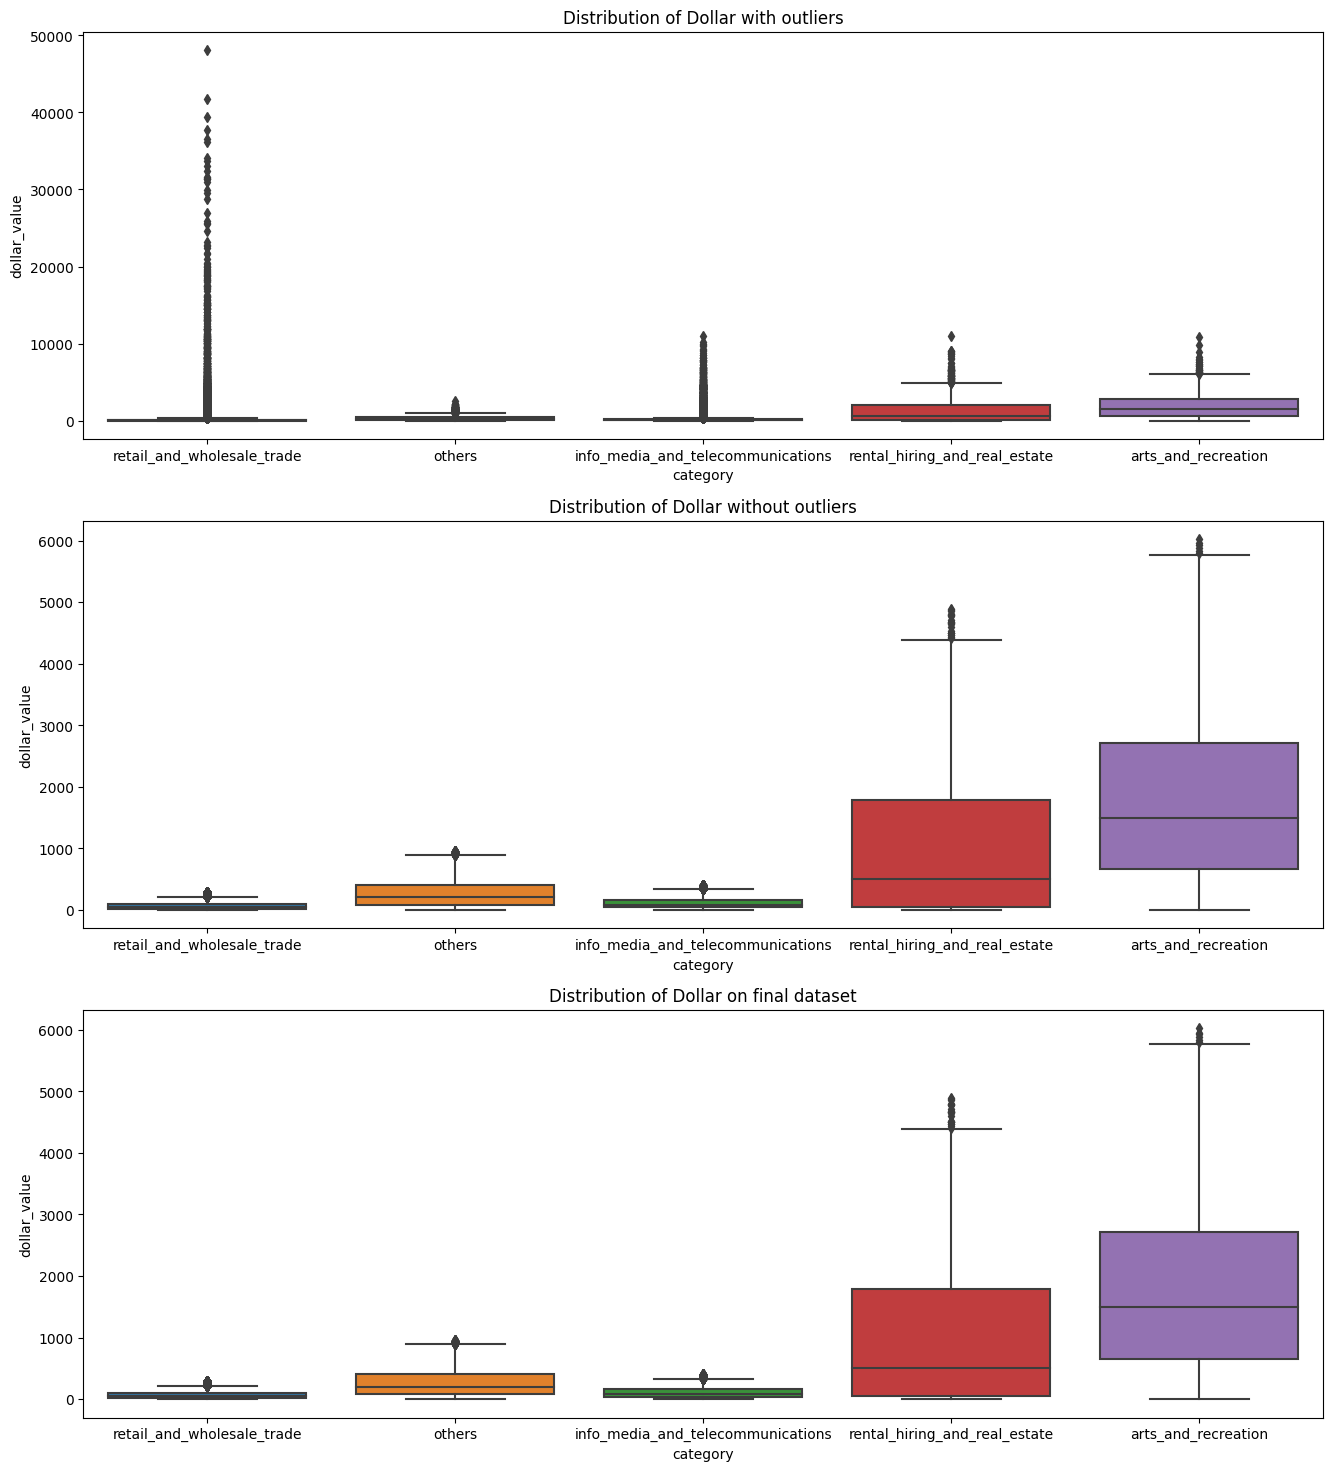

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

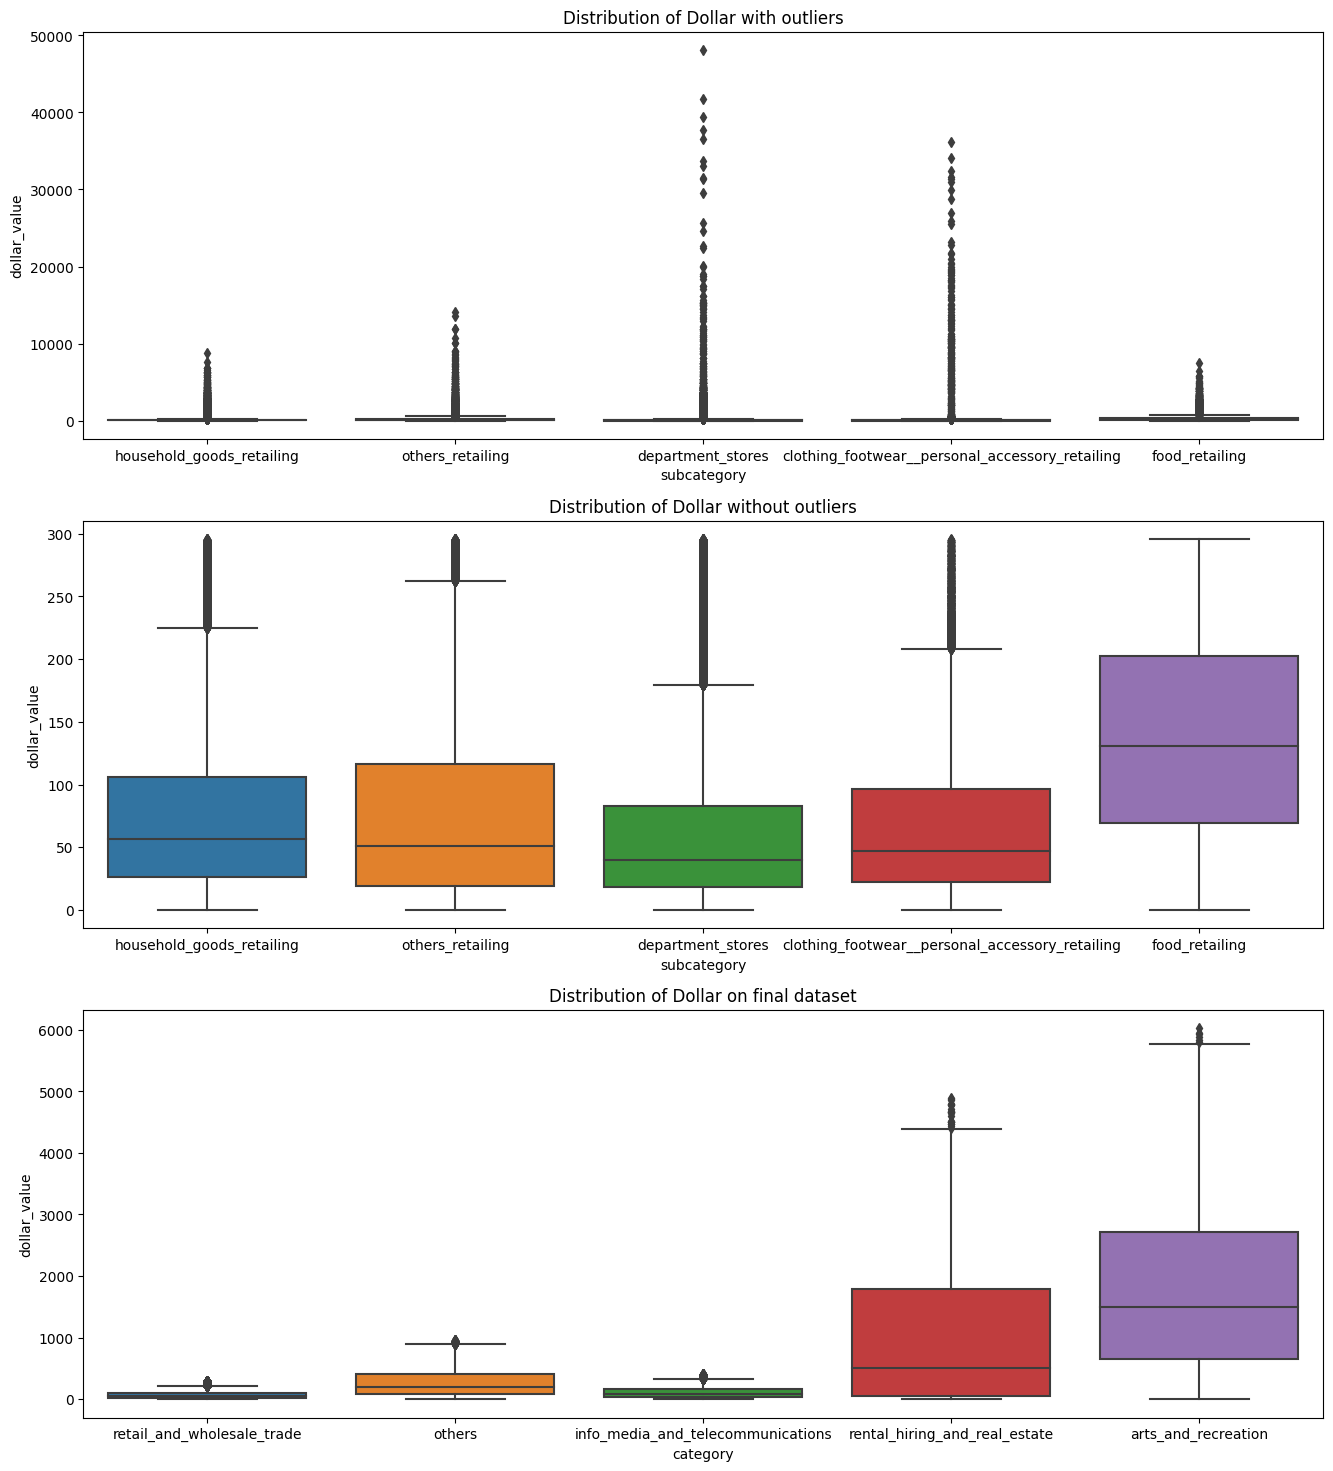

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

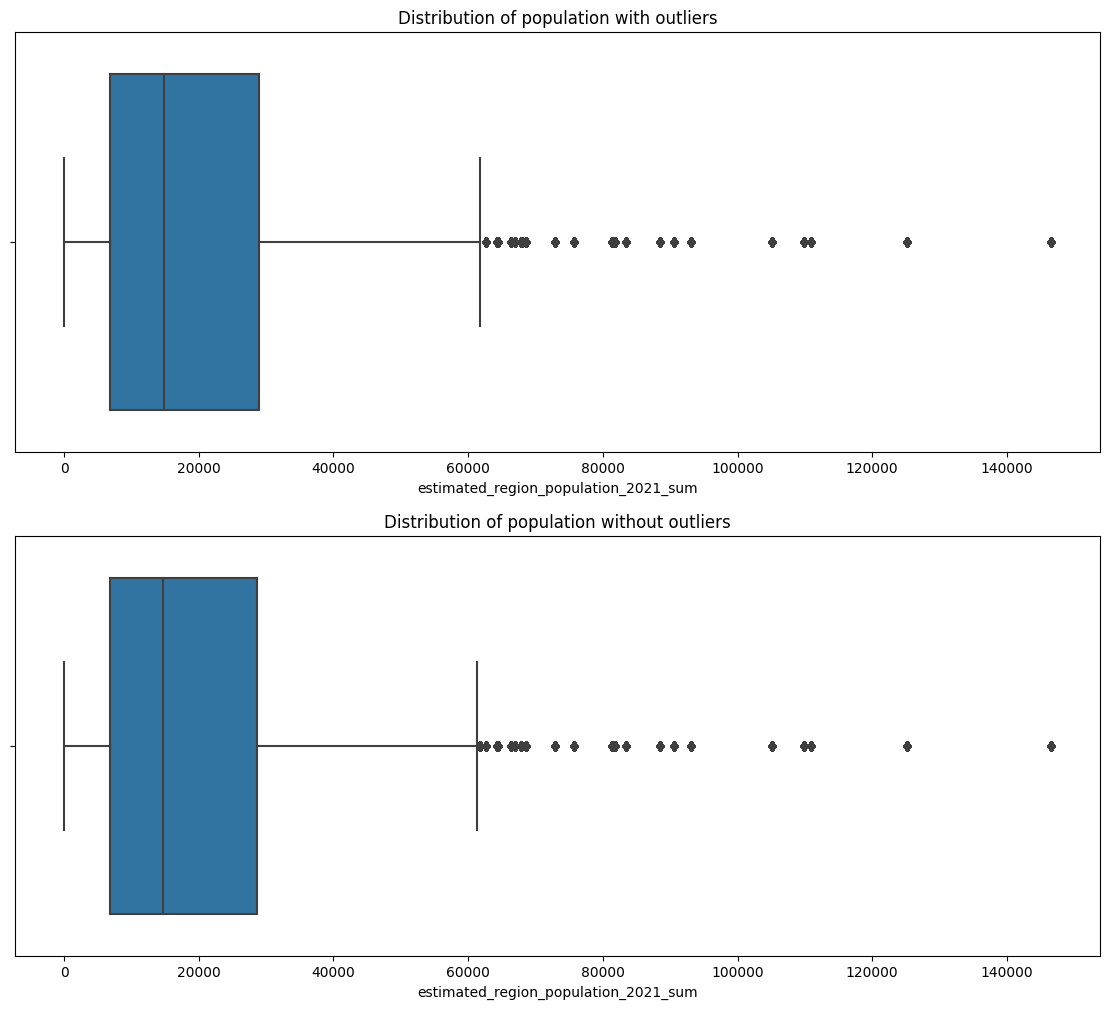

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = sns.boxplot(ax= axes[0], data=dataset_wo_outliers_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=final_dataset_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population without outliers')

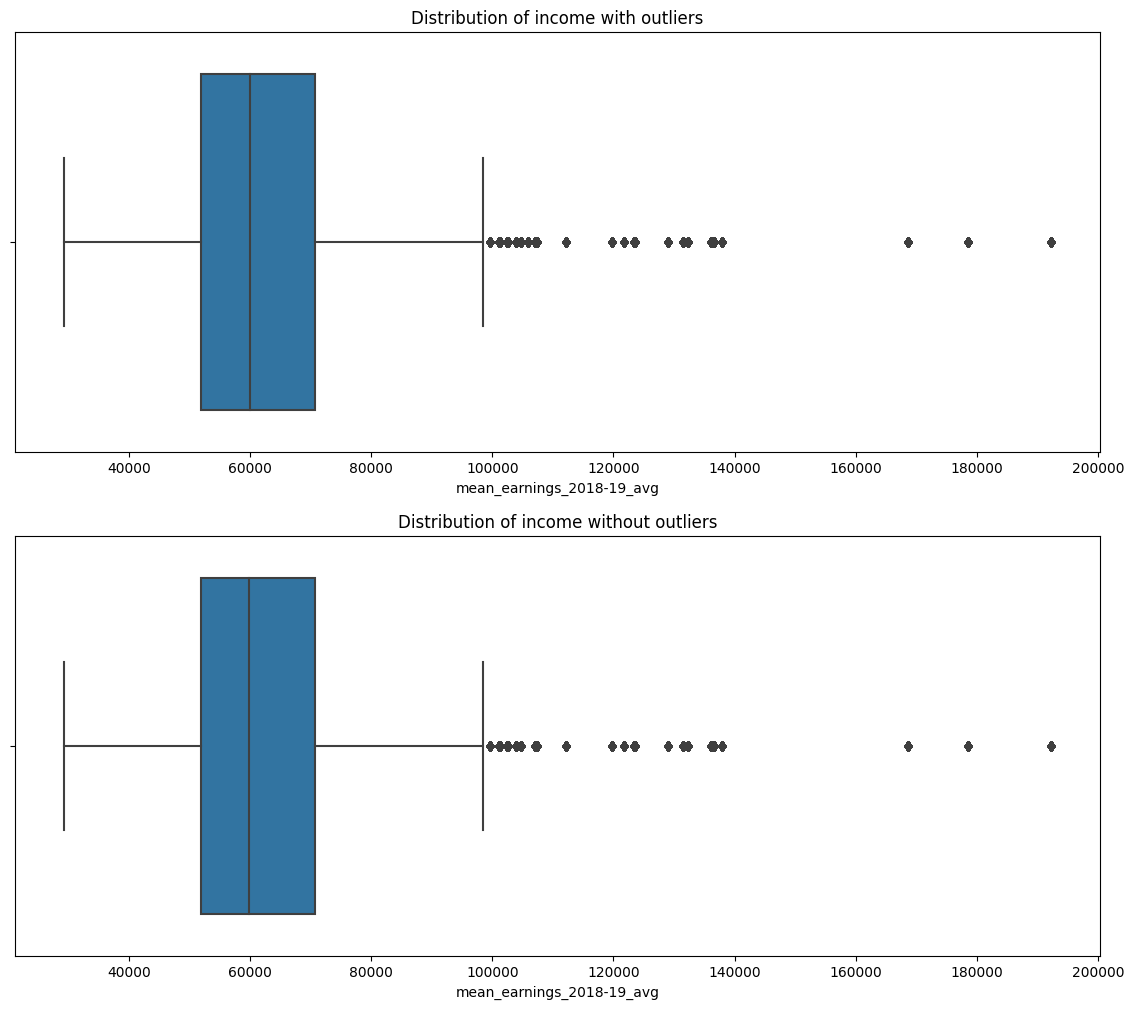

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = sns.boxplot(ax= axes[0], data=dataset_wo_outliers_df, x="mean_earnings_2018-19_avg").set(title = 'Distribution of income with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=final_dataset_df, x="mean_earnings_2018-19_avg").set(title = 'Distribution of income without outliers')

## Relationship between Features

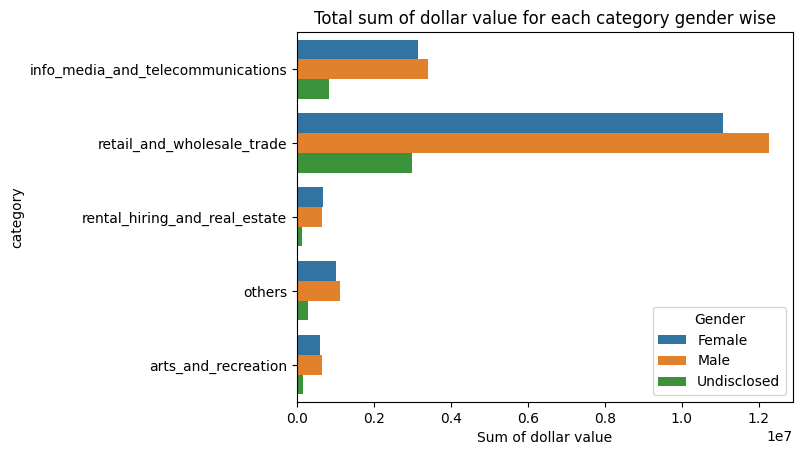

In [37]:
gender_category = final_dataset.groupBy('category', 'gender').sum('dollar_value')
sns.barplot(data= gender_category.toPandas(), x= 'sum(dollar_value)', y="category", hue="gender")
plt.title('Total sum of dollar value for each category gender wise')
plt.xlabel('Sum of dollar value')
plt.legend(loc='lower right', title='Gender')

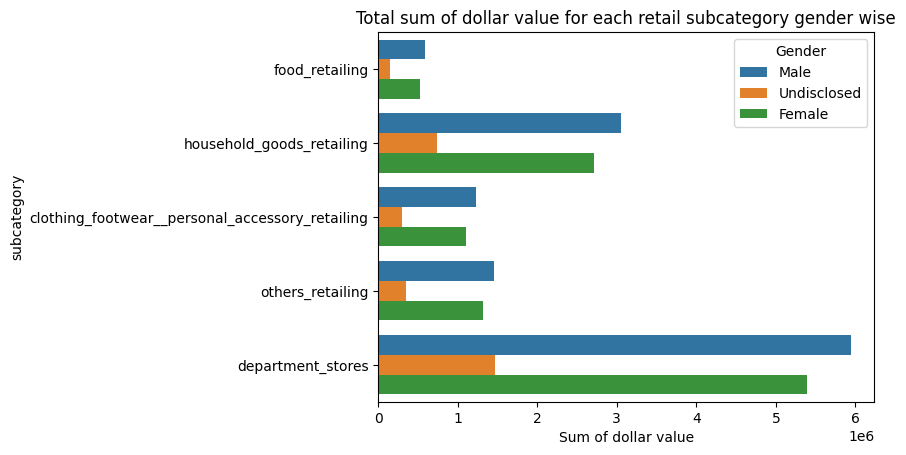

In [38]:
gender_subcategory = final_dataset.groupBy('subcategory', 'gender').sum('dollar_value')
sns.barplot(data= gender_subcategory.toPandas(), x= 'sum(dollar_value)', y="subcategory", hue="gender")
plt.title('Total sum of dollar value for each retail subcategory gender wise')
plt.xlabel('Sum of dollar value')
plt.legend(loc='upper right', title='Gender')

Text(0, 0.5, 'Sum of dollar value')

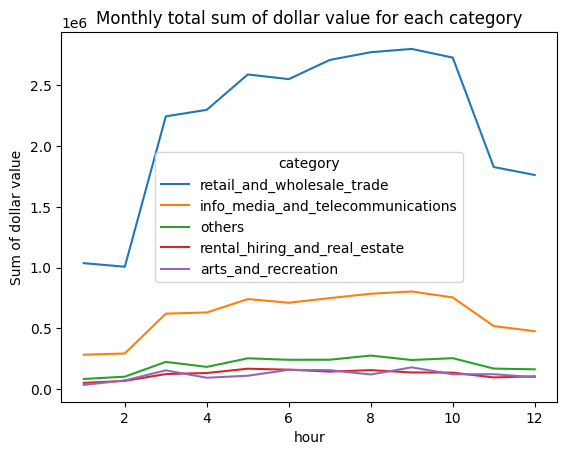

In [39]:
category_monthly = final_dataset.withColumn('hour', month(final_dataset.order_datetime)).groupBy('category', 'hour').sum('dollar_value')
sns.lineplot(data= category_monthly.toPandas(), x= 'hour', y= 'sum(dollar_value)', hue= 'category')
plt.title('Monthly total sum of dollar value for each category')
plt.ylabel('Sum of dollar value')

Text(0, 0.5, 'Sum of dollar value')

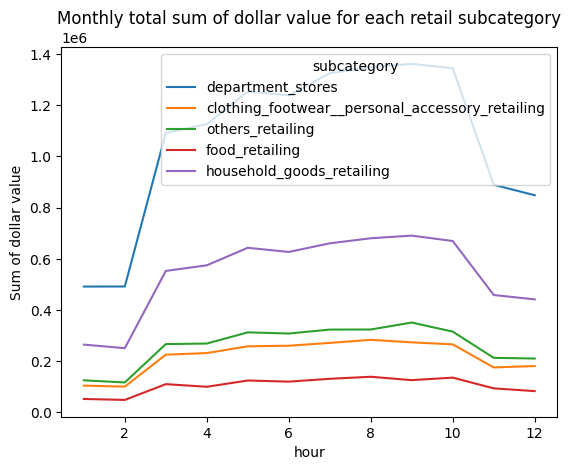

In [40]:
subcategory_monthly = final_dataset.withColumn('hour', month(final_dataset.order_datetime)).groupBy('subcategory', 'hour').sum('dollar_value')
subcategory_monthly = subcategory_monthly.na.drop()
sns.lineplot(data= subcategory_monthly.toPandas(), x= 'hour', y= 'sum(dollar_value)', hue= 'subcategory')
plt.title('Monthly total sum of dollar value for each retail subcategory')
plt.ylabel('Sum of dollar value')

<AxesSubplot: xlabel='state', ylabel='sum(dollar_value)'>

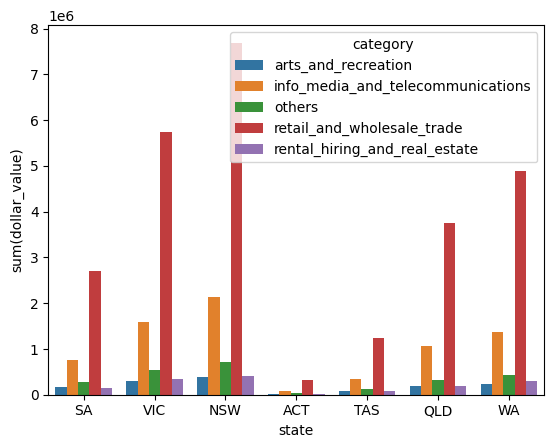

In [22]:
state_category = final_dataset.groupBy('category', 'state').sum('dollar_value')
sns.barplot(data= state_category.toPandas(), x= "state", y= "sum(dollar_value)", hue= "category")
plt.title('Total sum of dollar value for each category state wise')
plt.ylabel('Sum of dollar value')

Text(0, 0.5, 'Sum of dollar value')

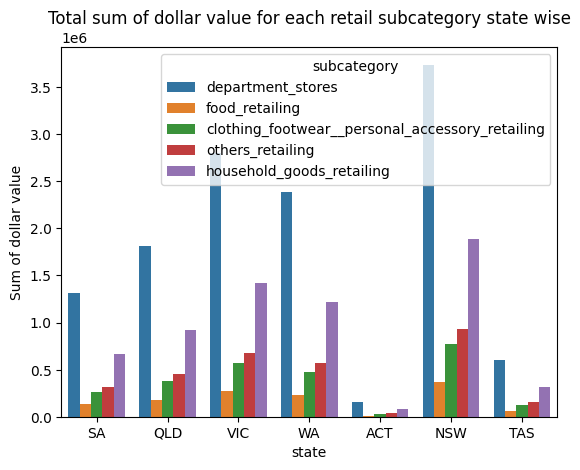

In [41]:
state_subcategory = final_dataset.groupBy('subcategory', 'state').sum('dollar_value')
sns.barplot(data= state_subcategory.toPandas(), x= "state", y= "sum(dollar_value)", hue= "subcategory")
plt.title('Total sum of dollar value for each retail subcategory state wise')
plt.ylabel('Sum of dollar value')